# Clasificacion de imagenes con Redes Tensoriales

Este codigo es una adaptacion en Python del codigo del profesor Dr Jan von Delft hecho en Matlab para su curso "Tensor Networks" el cual pueden visitar acá: [Tutorials](https://www.physik.uni-muenchen.de/lehre/vorlesungen/sose_19/tensor_networks_19/uebungen/index.html)

**Objetivo:** Construir funcion de decision $\vec{f}$ usando redes tensoriales (aqui MPS), la red se entrena usando tecnicas de optimizacion familiares al DMRG.

<center>$\vec{f}: \vec{x} \rightarrow \vec{f}(\vec{x}) \equiv \langle \vec{W} |\Phi(\vec{x}) \rangle$</center>

**'funcion de Caracteristicas':** $\Phi: \vec{x} \rightarrow |\Phi(\vec{x})\rangle:$ codifica los pixeles en escala de grises en un MPS de orden $L$, $|\Phi(\vec{x})\rangle$

**'vector de peso':** $\vec{W}: |\Phi(\vec{x})\rangle \rightarrow f^j(\vec{x}) \equiv \langle W^j |\Phi(\vec{x}) \rangle, \hspace{5mm} j=0,1,...,9$.
<br>
convierte el mapa de características en el nombre predicho a través del producto interno con un tensor MPS de orden $L$, $| W^j \rangle$

**'Nombre predicho':** La etiqueta $j$ para la cual $f^j$ es maxima

<img src="https://drive.google.com/uc?export=view&id=1irenz8ZSbCgOYMBffjN3EIb02ECRCSSR" width="300">


## Carga de datos MNIST

In [1]:
from keras.datasets import mnist
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from skimage.transform import rescale
from math import pi
from ncon import ncon
import datetime
import random
#import tensornetwork
#from tensornetwork import ncon
#import tensorflow as tf
#net = tensornetwork.TensorNetwork()
#sess = tf.InteractiveSession()

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
print('Hay', X_train.shape[0], 'datos de entrenamiento y',  X_test.shape[0], 
      'datos de prueba.\nLas imagenes tienen un tamaño de', X_train.shape[1],'x',
      X_train.shape[2], 'pixeles y estan \nen una escala de grises que va de negro',
     np.amin(X_train),'a blanco',np.amax(X_train))

Hay 60000 datos de entrenamiento y 10000 datos de prueba.
Las imagenes tienen un tamaño de 28 x 28 pixeles y estan 
en una escala de grises que va de negro 0 a blanco 255


### Usaremos solo un subconjunto de los datos de prueba y entrenamiento para agiliazar los calculos

In [3]:
#Normalizamos
X_train = np.copy(X_train[:2000,:,:])/255
X_test = np.copy(X_test[:100,:,:])/255
Y_train = np.copy(Y_train[:2000])
Y_test = np.copy(Y_test[:100])

In [4]:
print('\nNumero de ocurrencias de cada clase de numeros:')
print(np.vstack((np.unique(Y_train), np.bincount(Y_train))).T)


Numero de ocurrencias de cada clase de numeros:
[[  0 191]
 [  1 220]
 [  2 198]
 [  3 191]
 [  4 214]
 [  5 180]
 [  6 200]
 [  7 224]
 [  8 172]
 [  9 210]]


## Graficar primeras 36 imagenes de MNIST

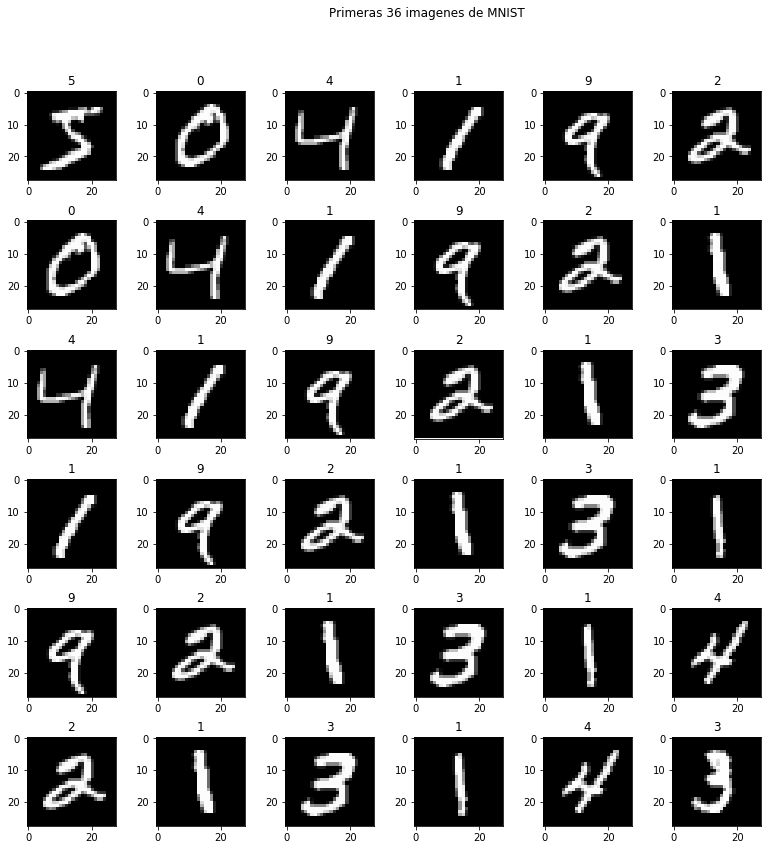

In [5]:
fig, ax = plt.subplots(6,6, figsize = (12, 12))
fig.suptitle('Primeras 36 imagenes de MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y], cmap = 'gray')
    ax[x, y].set_title(Y_train[x + y])

### En el articulo de Stoudenmire, el tamaño de las imagenes son reducidas (Coarse-graining) un factor de 2. Al hacer esto, podremos usar un MPS mas pequeño de longitud $14² = 196$

In [6]:
l = []

for i in range(len(X_train)):
    l.append(rescale(X_train[i,:,:], 0.5, anti_aliasing=True,multichannel=False))

r = []

for i in range(len(X_test)):
    r.append(rescale(X_test[i,:,:], 0.5, anti_aliasing=True,multichannel=False))

X_train = np.array(l)
X_test = np.array(r)


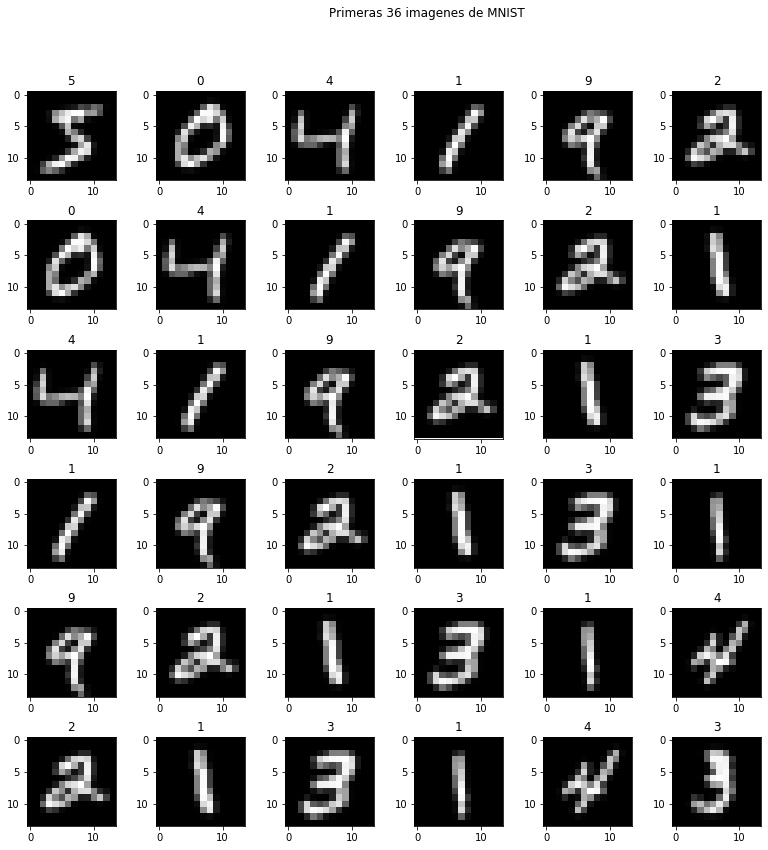

In [7]:
fig, ax = plt.subplots(6,6, figsize = (12, 12))
fig.suptitle('Primeras 36 imagenes de MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y], cmap = 'gray')
    ax[x, y].set_title(Y_train[x + y])

### Las primeras 36 imagenes estan etiquetadas como:

In [8]:
Y_train[:36]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5], dtype=uint8)

### Representacion en One-Hot encoding de las etiquetas 

In [9]:
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [10]:
print(Y_train.shape)

(2000, 10)


In [11]:
print(Y_train[0:35])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0.

## Generar vectores de caracteristicas

Los pixeles son mapeados individualmente a vectores bidimensionales llamados vectores de caracteristicas.

En el articulo de Stoudenmire proveen la correspondencia uno a uno entre un pixel y un vector

<img src="https://drive.google.com/uc?export=view&id=1F5_xJq48sTkkVfYn8k360G5A2_PWGDPo" width="400">

Ésta contruccion de $|\Phi(\vec{x})\rangle$ no es unica. Otras construcciones son posibles siempre que $\langle\Phi(\vec{x})|\Phi(\vec{x})\rangle$ sea una función de $\vec{x}$ y $\vec{x}'$ que varía suave y lentamente que induce una 'matriz de distancia' en el espacio de características que tiende a agrupar imágenes similares.

### Ordenamiento de los pixeles en forma de serpiente

In [12]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        if j%2!=0:
            X_train[i,j,::1] = X_train[i,j,::-1]

In [13]:
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        if j%2!=0:
            X_test[i,j,::1] = X_test[i,j,::-1]

## vectores de caracteristicas

In [14]:
dtmp = X_train*(pi/2)
F_train = np.concatenate((np.cos(dtmp.reshape(dtmp.shape[0],1,dtmp.shape[1]**2)),
                          np.sin(dtmp.reshape(dtmp.shape[0],1,dtmp.shape[1]**2))),axis=1)
#F_train(m,:,n) es un vector de caracteristicas 2-dimensional para el n-esimo pixel y la m-esima imagen
dtmp = X_test*(pi/2)
F_test = np.concatenate((np.cos(dtmp.reshape(dtmp.shape[0],1,dtmp.shape[1]**2)),
                          np.sin(dtmp.reshape(dtmp.shape[0],1,dtmp.shape[1]**2))),axis=1)

print(F_train.shape)
print(F_test.shape)

# Verificar que todos los valores sean mayores que cero
print(np.all(F_train >= 0))
print(np.all(F_test >= 0))

(2000, 2, 196)
(100, 2, 196)
True
True


## Vector de peso: codificar el patron de reconocimiento

#### Inicializar MPS 

In [15]:
chi = 20; # dimension interna
chid = 2; #dimension externa
Nsites = X_train.shape[1]**2; # longitud de MPS
label = Y_train.shape[1] # numero de etiquetas

A = [0 for x in range(Nsites)] # tensores de la red MPS
A[0] = np.random.rand(1,chid,chi) #orden: left(1)-physical(2)-right(20)
A[Nsites-1] = np.random.rand(chi,chid,1,label) #orden: left(20)-physical(2)-right(1)-label(10)
for k in range(1,Nsites-1):
    A[k] = np.random.rand(chi,chid,chi) #orden: left(20)-physical(2)-right(20)

#### Llevar a forma canonica a izquierda

In [16]:
for p in range(Nsites-1):
        chil = A[p].shape[0]*A[p].shape[1]; chir = A[p].shape[2];
        Q, R = LA.qr(A[p].reshape(chil,chir));
        A[p] = Q.reshape(A[p].shape[0],A[p].shape[1],Q.shape[1])
        if p < Nsites - 2:
            A[p+1] = ncon([R,A[p+1]],[[-1,1],[1,-2,-3]])/LA.norm(R)
        else:
            A[p+1] = ncon([R,A[p+1]],[[-1,1],[1,-2,-3,-4]])/LA.norm(R)

In [17]:
ncon([A[0],A[0]],[[1,2,-1],[1,2,-2]])

array([[1.00000000e+00, 5.55111512e-17],
       [5.55111512e-17, 1.00000000e+00]])

## Aprendizaje de maquina con MPS

In [18]:
# Verificar input
if F_train.shape[2] != Y_train.shape[0]:
    IndexError('ERR: El tamaño de F_train y Y_train es inconsistente.')
elif F_test.shape[2] != Y_test.shape[0]:
    IndexError('ERR: El tamaño de F_test y Y_test es inconsistente.')
elif Y_train.shape[1] != Y_test.shape[1]:
    IndexError('ERR: # de etiquetas para Y_train y Y_test es inconsistente.')
    

In [19]:
# matrices de resultados
estep = np.repeat(0.3, 4)
sweep = 2*len(estep)

cfun = np.zeros((sweep,Nsites-1)) # función de costo para datos de entrenamiento
err = np.zeros((sweep,Nsites-1)) # tasa de error para datos de entrenamiento
cfun_test = np.zeros((sweep,Nsites-1)) # función de costo para datos de prueba
err_test = np.zeros((sweep,Nsites-1)) # tasa de error para datos de prueba

In [20]:
print('Aprendizaje automático usando MPS\n')
print('  Longitud = ',Nsites,', # datos de entrenamiento = ',F_train.shape[2],', # datos prueba = '
      ,F_test.shape[2],'\n')
print('  # etiquetas = ', Y_train.shape[1],', maxima dimension interna = ',chi,', {} barridos\n'.format(sweep))


Aprendizaje automático usando MPS

  Longitud =  196 , # datos de entrenamiento =  196 , # datos prueba =  196 

  # etiquetas =  10 , maxima dimension interna =  20 , 8 barridos



### Actualizar vectores de características en la base efectiva

In [21]:
## Para datos de entrenamiento

Flr_train = [0 for x in range(Nsites+2)]; 

for p in range(Nsites-2):
    T = A[p]
    if np.all(Flr_train[p] != 0):
        T = np.sum(Flr_train[p][:,:,np.newaxis,np.newaxis]*T[np.newaxis,:,:,:],axis=1)
    T = np.sum(F_train[:,:,p][:,:,np.newaxis]*T,axis=1)
    Flr_train[p+1] = T/(np.amax(np.abs(T),axis=1)[:,np.newaxis])
    
#Para datos de prueba

Flr_test = [0 for x in range(Nsites+2)]; 

for p in range(Nsites-2):
    T = A[p]
    if np.all(Flr_test[p] != 0):
        T = np.sum(Flr_test[p][:,:,np.newaxis,np.newaxis]*T[np.newaxis,:,:,:],axis=1)
    T = np.sum(F_test[:,:,p][:,:,np.newaxis]*T,axis=1)
    Flr_test[p+1] = T/(np.amax(np.abs(T),axis=1)[:,np.newaxis])


In [22]:
def MPS_update(B,F1,F2,F3,F4,y,update=False):
    
    fx = B
    if np.all(F1 != 0):
        fx = np.sum(F1[:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis]*fx[np.newaxis,:,:,:,:,:],axis=1)
    fx = np.sum(F2[:,:,np.newaxis,np.newaxis,np.newaxis]*fx,axis=1)
    fx = np.sum(F3[:,:,np.newaxis,np.newaxis]*fx,axis=1)
    if np.all(F4 != 0):
        fx = np.sum(F4[:,:,np.newaxis]*fx,axis=1)
    else:
        fx = np.squeeze(fx,axis=1)
        
    #Medir tasa de error de la funcion de decision
    
    ERR = 1.0 - y[[i for i in range(len(y))],[np.argmax(fx,axis=1)]].sum()/len(y)
    
    # Desviacion de la funcion de decision del valor correcto
    
    ydiff = y - fx;
    
    # Calculo de la funcion de decision por conjunto de datos
    
    CFUN = np.sum(np.abs(ydiff**2),axis=1).sum()/(2*len(y))
    
    # Calculo de dB 
    
    if update:
        
        dB = ydiff[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,:]
        
        if np.all(F1 != 0 ):
            dB = F1[:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis]*dB
        dB = F2[:,np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]*dB
        dB = F3[:,np.newaxis,np.newaxis,:,np.newaxis,np.newaxis]*dB
        if np.all(F4 != 0 ):
            dB = F4[:,np.newaxis,np.newaxis,np.newaxis,:,np.newaxis]*dB
        
        dB = np.mean(dB,axis=0)
        
        return ERR, CFUN, dB
    return ERR, CFUN
    

In [23]:
now = datetime.datetime.now()
print (now.strftime("%Y-%m-%d %H:%M:%S"), "Comienzo de barrido")

for its in range(len(estep)):
    # Izq <-- Der
    for itn in range(Nsites-1,0,-1):

        B = ncon([A[itn-1],A[itn]],[[-1,-2,1],[1,-3,-4,-5]])
            # orden de indices M{itn-1}: left-physical-right
            # orden de indices M{itn}: left-physical-right-label
            # orden de indices B: left-physical(itn-1)-physical(itn)-right-label

        # para datos de prueba, calcule solo la función de costo 
        # y la tasa de error
        err_test[2*its,(Nsites-1)-itn], cfun_test[2*its,(Nsites-1)-itn] = MPS_update(B,Flr_test[itn-1],F_test[:,:,itn-1],
                                                                                     F_test[:,:,itn],Flr_test[itn+2],
                                                                                     Y_test,False)
        
        # calcular la función de costo, tasa de error y gradiente de B
        err[2*its,(Nsites-1)-itn], cfun[2*its,(Nsites-1)-itn], db = MPS_update(B,Flr_train[itn-1],F_train[:,:,itn-1],
                                                                               F_train[:,:,itn],Flr_train[itn+2],
                                                                               Y_train,True)
        # actualizar el tensor B
        B = B + db*estep[its]

        # Hacer SVD para actualizar A[itn-1] y A[itn]
        # Asociar el indice de etiquetas a A[itn-1] 
        chil = B.shape[0]*B.shape[1]*B.shape[4];  chir = B.shape[2]*B.shape[3]

        U, S, V = LA.svd(B.reshape(chil,chir),full_matrices=False)

        if S.shape[0] > chi:
            U = U[:,:chi]
            S = S[:chi]
            V = V[:chi,:]

        A[itn] = V.reshape(S.shape[0],A[itn].shape[1],A[itn].shape[2])
        # orden de indices: left-physical-right-label
        A[itn-1] = (U @ (np.diag(S)/LA.norm(S))).reshape(A[itn-1].shape[0],A[itn-1].shape[1],S.shape[0],B.shape[4])


        # actualizar Flr_train[itn+1] de acuerdo al nuevo A[int]

        T = A[itn].transpose(2,1,0)
        if np.all(Flr_train[itn+2] != 0):
            T = np.sum(Flr_train[itn+2][:,:,np.newaxis,np.newaxis]*T[np.newaxis,:,:,:],axis=1)
        T = np.sum(F_train[:,:,itn][:,:,np.newaxis]*T,axis=1)
        Flr_train[itn+1] = T/(np.amax(np.abs(T),axis=1)[:,np.newaxis])

        # actualizar Flr_test[itn+1] de acuerdo al nuevo A[int]

        T = A[itn].transpose(2,1,0)
        if np.all(Flr_test[itn+2] != 0):
            T = np.sum(Flr_test[itn+2][:,:,np.newaxis,np.newaxis]*T[np.newaxis,:,:,:],axis=1)
        T = np.sum(F_test[:,:,itn][:,:,np.newaxis]*T,axis=1)
        Flr_test[itn+1] = T/(np.amax(np.abs(T),axis=1)[:,np.newaxis])
        
    now = datetime.datetime.now()
    print (now.strftime("\n %Y-%m-%d %H:%M:%S"), "|\t Barrido: #{}/{}".format(2*(its+1)-1,sweep), 
           "|\t izq <- der", "|\t eta = {}".format(estep[its]), 
           "\n Entrenamiento: cost fun = {}".format(cfun[2*(its),(Nsites-2)]), 
           "\t tasa de error = {}".format(err[2*(its),(Nsites-2)]),
           "\n Prueba: cost fun = {}".format(cfun_test[2*(its),(Nsites-2)]),
           "\t tasa de error = {}".format(err_test[2*(its),(Nsites-2)]))
    
    # izquierda -> derecha
    for itn in range(1,Nsites):
        B = ncon([A[itn-1],A[itn]],[[-1,-2,1,-5],[1,-3,-4]])
            # orden de indices M{itn-1}: left-physical-right-label
            # orden de indices M{itn}: left-physical-right
            # orden de indices B: left-physical(itn-1)-physical(itn)-right-label

        # para datos de prueba, calcule solo la función de costo 
        # y la tasa de error
        err_test[2*its+1,itn-1], cfun_test[2*its+1,itn-1] = MPS_update(B,Flr_test[itn-1],F_test[:,:,itn-1],
                                                                       F_test[:,:,itn],Flr_test[itn+2],
                                                                       Y_test,False)


        # calcular la función de costo, tasa de error y gradiente de B
        err[2*its+1,itn-1], cfun[2*its+1,itn-1], dB = MPS_update(B,Flr_train[itn-1],F_train[:,:,itn-1],
                                                                 F_train[:,:,itn],Flr_train[itn+2],
                                                                 Y_train,True)

        # actualizar el tensor B
        B = B + dB*estep[its]

        # Hacer SVD para actualizar A[itn-1] y A[itn]
        # Asociar el indice de etiquetas a A[itn-1] 
        chil = B.shape[0]*B.shape[1];  chir = B.shape[2]*B.shape[3]*B.shape[4]

        U, S, V = LA.svd(B.reshape(chil,chir),full_matrices=False)

        if S.shape[0] > chi:
            U = U[:,:chi]
            S = S[:chi]
            V = V[:chi,:]

        A[itn-1] = U.reshape(A[itn-1].shape[0],A[itn-1].shape[1],S.shape[0])
        # orden de indices: left-physical-right-label
        A[itn] = ((np.diag(S)/LA.norm(S)) @ V).reshape(S.shape[0],A[itn].shape[1],A[itn].shape[2],B.shape[4])
        
        # actualizar Flr_train[itn] de acuerdo al nuevo A[int-1]

        T = A[itn-1]
        if np.all(Flr_train[itn-1] != 0):
            T = np.sum(Flr_train[itn-1][:,:,np.newaxis,np.newaxis]*T[np.newaxis,:,:,:],axis=1)
        T = np.sum(F_train[:,:,itn-1][:,:,np.newaxis]*T,axis=1)
        Flr_train[itn] = T/(np.amax(np.abs(T),axis=1)[:,np.newaxis])

        # actualizar Flr_test[itn] de acuerdo al nuevo A[int-1]

        T = A[itn-1]
        if np.all(Flr_test[itn-1] != 0):
            T = np.sum(Flr_test[itn-1][:,:,np.newaxis,np.newaxis]*T[np.newaxis,:,:,:],axis=1)
        T = np.sum(F_test[:,:,itn-1][:,:,np.newaxis]*T,axis=1)
        Flr_test[itn] = T/(np.amax(np.abs(T),axis=1)[:,np.newaxis])
        
    now = datetime.datetime.now()
    print (now.strftime("\n %Y-%m-%d %H:%M:%S"), "|\t Barrido: #{}/{}".format(2*(its+1),sweep), 
           "|\t izq -> der", "|\t eta = {}".format(estep[its]), 
           "\n Entrenamiento: cost fun = {}".format(cfun[2*(its)+1,itn-1]), 
           "\t tasa de error = {}".format(err[2*(its)+1,itn-1]),
           "\n Prueba: cost fun = {}".format(cfun_test[2*(its)+1,itn-1]),
           "\t tasa de error = {}".format(err_test[2*(its)+1,itn-1]))


2019-10-23 09:57:28 Comienzo de barrido

 2019-10-23 09:59:57 |	 Barrido: #1/8 |	 izq <- der |	 eta = 0.3 
 Entrenamiento: cost fun = 0.5212596278681736 	 tasa de error = 0.8815 
 Prueba: cost fun = 0.526334400707951 	 tasa de error = 0.9

 2019-10-23 10:02:26 |	 Barrido: #2/8 |	 izq -> der |	 eta = 0.3 
 Entrenamiento: cost fun = 0.32538687755781676 	 tasa de error = 0.373 
 Prueba: cost fun = 0.3321625169866769 	 tasa de error = 0.32999999999999996

 2019-10-23 10:04:56 |	 Barrido: #3/8 |	 izq <- der |	 eta = 0.3 
 Entrenamiento: cost fun = 0.5801988151256703 	 tasa de error = 0.9105 
 Prueba: cost fun = 0.6022711439110154 	 tasa de error = 0.94

 2019-10-23 10:07:27 |	 Barrido: #4/8 |	 izq -> der |	 eta = 0.3 
 Entrenamiento: cost fun = 0.27774363432266297 	 tasa de error = 0.247 
 Prueba: cost fun = 0.2876318213861823 	 tasa de error = 0.26

 2019-10-23 10:09:58 |	 Barrido: #5/8 |	 izq <- der |	 eta = 0.3 
 Entrenamiento: cost fun = 0.5510619952663824 	 tasa de error = 0.8815 
 Pru